# RNN (Rekurrent Neyron Şəbəkələri) ilə Bitcoin Qiymət Proqnozlaşdırma

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
import tensorflow as tf
from datetime import datetime, timedelta

np.random.seed(42)
tf.random.set_seed(42)

## Bitcoin verilənlərini yükləyirik

In [2]:
btc_data = yf.download('BTC-USD', start='2020-01-01', end=datetime.now().strftime('%Y-%m-%d'))
print("Bitcoin verilənləri yükləndi. Verilənlərin ölçüsü:", btc_data.shape)
print("İlk 5 sətir:")
btc_data.head()

Bitcoin verilənləri yüklənir...
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Bitcoin verilənləri yükləndi. Verilənlərin ölçüsü: (1963, 5)
İlk 5 sətir:


Price,Close,High,Low,Open,Volume
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
Date,,,,,
2020-01-01,7200.174316,7254.330566,7174.944336,7194.892090,18565664997
2020-01-02,6985.470215,7212.155273,6935.270020,7202.551270,20802083465
2020-01-03,7344.884277,7413.715332,6914.996094,6984.428711,28111481032
2020-01-04,7410.656738,7427.385742,7309.514160,7345.375488,18444271275
2020-01-05,7411.317383,7544.497070,7400.535645,7410.451660,19725074095


## Verilənləri vizuallaşdırırıq

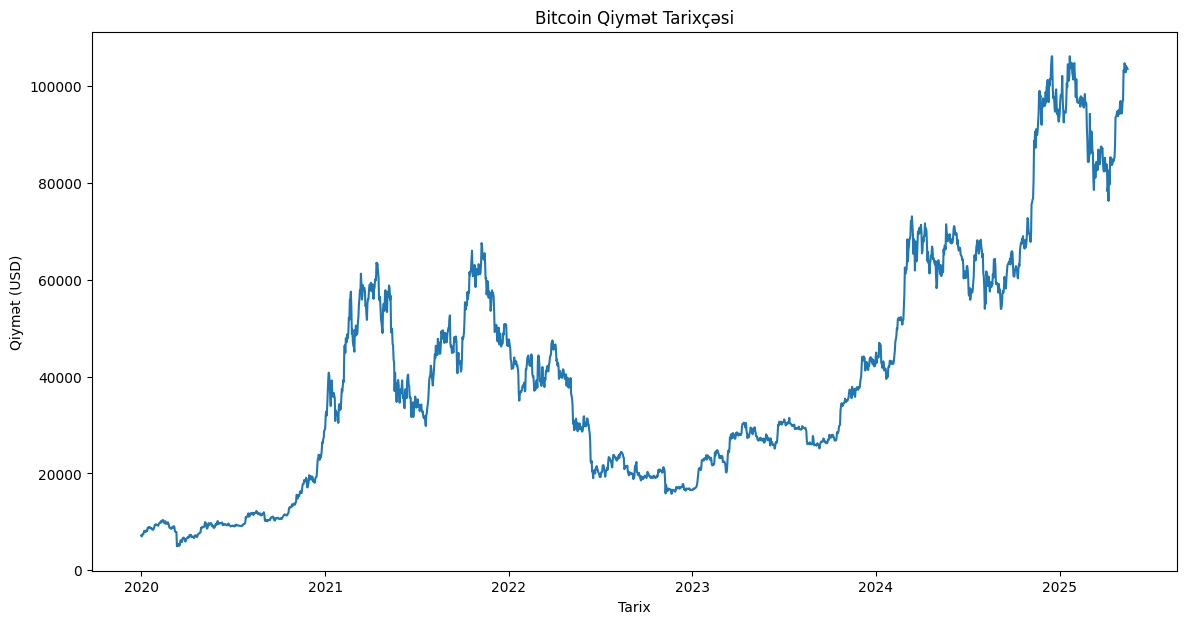

In [3]:
plt.figure(figsize=(14, 7))
plt.title('Bitcoin Qiymət Tarixçəsi')
plt.plot(btc_data['Close'])
plt.xlabel('Tarix')
plt.ylabel('Qiymət (USD)')
plt.show()

## Verilənləri hazırlayırıq

In [4]:
data = btc_data['Close'].values.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

print(f"Train verilənlərinin ölçüsü: {train_data.shape}")
print(f"Test verilənlərinin ölçüsü: {test_data.shape}")

Train verilənlərinin ölçüsü: (1570, 1)
Test verilənlərinin ölçüsü: (393, 1)


## RNN üçün verilənləri hazırlayırıq

In [5]:
def create_dataset(data, time_steps=60):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps, 0])
        y.append(data[i+time_steps, 0])
    return np.array(X), np.array(y)

time_steps = 60  
X_train, y_train = create_dataset(train_data, time_steps)
X_test, y_test = create_dataset(test_data, time_steps)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print(f"Train verilənlərinin forması: {X_train.shape}")
print(f"Test verilənlərinin forması: {X_test.shape}")

Train verilənlərinin forması: (1510, 60, 1)
Test verilənlərinin forması: (333, 60, 1)


## LSTM modelini yaradırıq

In [6]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_steps, 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
print("Model yaradıldı və kompilyasiya edildi:")
model.summary()



Model yaradıldı və kompilyasiya edildi:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)

## Modeli öyrədirik

In [7]:
history = model.fit(X_train, y_train, epochs=25, batch_size=32, validation_split=0.1, verbose=1)

Model öyrədilir...
Epoch 1/25

43/43 [==============================] - 7s 69ms/step - loss: 0.0073 - val_loss: 0.0040
Epoch 2/25
43/43 [==============================] - 2s 46ms/step - loss: 0.0022 - val_loss: 0.0026
Epoch 3/25
43/43 [==============================] - 2s 46ms/step - loss: 0.0019 - val_loss: 0.0023
Epoch 4/25
43/43 [==============================] - 2s 46ms/step - loss: 0.0018 - val_loss: 0.0020
Epoch 5/25
43/43 [==============================] - 2s 46ms/step - loss: 0.0016 - val_loss: 0.0021
Epoch 6/25
43/43 [==============================] - 2s 46ms/step - loss: 0.0017 - val_loss: 0.0044
Epoch 7/25
43/43 [==============================] - 2s 45ms/step - loss: 0.0016 - val_loss: 0.0022
Epoch 8/25
43/43 [==============================] - 2s 46ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 9/25
43/43 [==============================] - 2s 46ms/step - loss: 0.0012 - val_loss: 0.0028
Epoch 10/25
43/43 [==============================] - 2s 46ms/step - loss: 0.0013 - val_lo

## Öyrənmə prosesini vizuallaşdırırıq

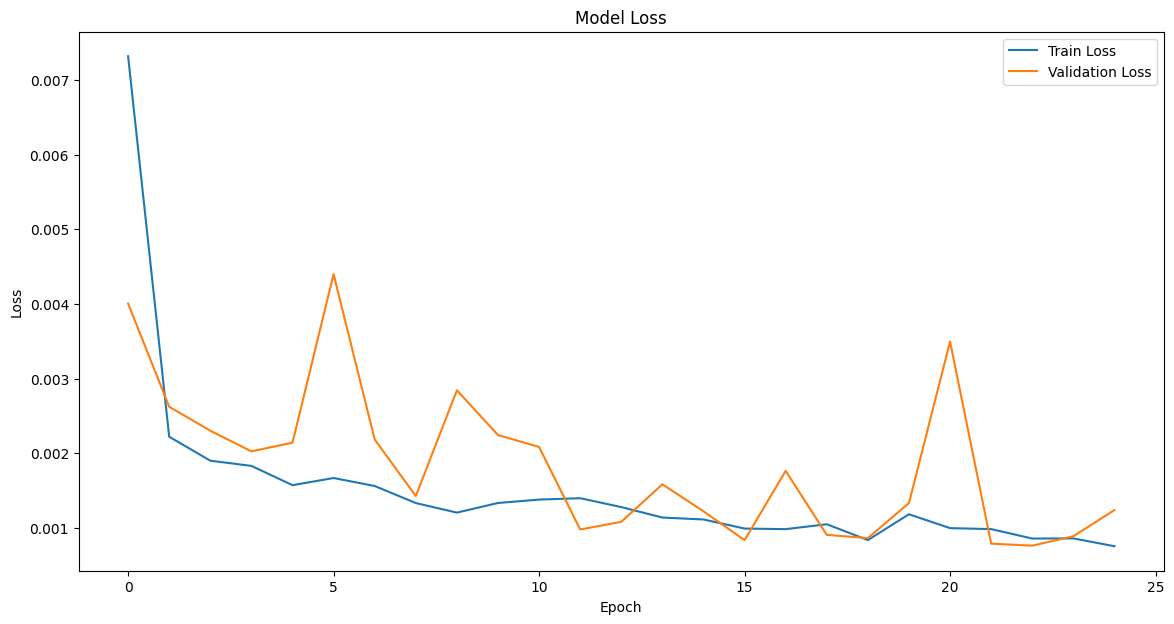

In [8]:
plt.figure(figsize=(14, 7))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Test verilənləri üzərində proqnozlar edirik

In [9]:
predicted = model.predict(X_test)
predicted = scaler.inverse_transform(predicted) 

y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

11/11 [==============================] - 1s 9ms/step


## Nəticələri vizuallaşdırırıq

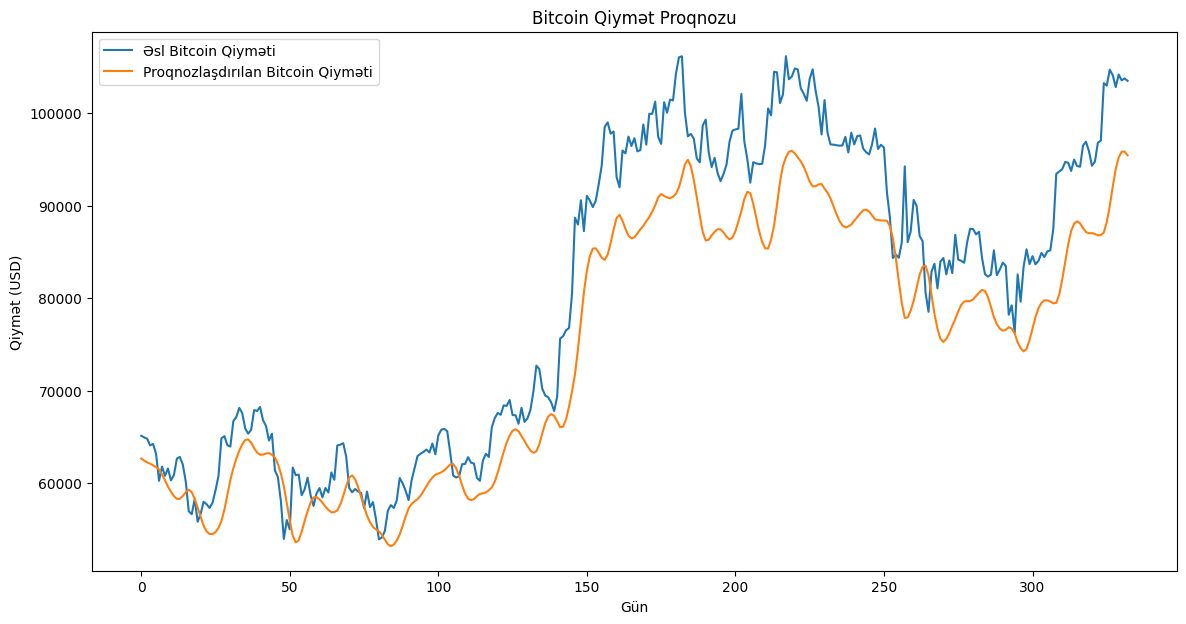

In [10]:
plt.figure(figsize=(14, 7))
plt.plot(y_test_actual, label='Əsl Bitcoin Qiyməti')
plt.plot(predicted, label='Proqnozlaşdırılan Bitcoin Qiyməti')
plt.title('Bitcoin Qiymət Proqnozu')
plt.xlabel('Gün')
plt.ylabel('Qiymət (USD)')
plt.legend()
plt.show()

## Modelin dəqiqliyini hesablayırıq

In [11]:
mse = np.mean((predicted - y_test_actual) ** 2)
rmse = np.sqrt(mse)
print(f"Orta kvadrat xəta (MSE): {mse:.2f}")
print(f"Kök orta kvadrat xəta (RMSE): {rmse:.2f}")

Orta kvadrat xəta (MSE): 49575108.95
Kök orta kvadrat xəta (RMSE): 7040.96


## Gələcək 30 gün üçün proqnoz

In [12]:
last_60_days = scaled_data[-60:].reshape(1, 60, 1)
future_predictions = []

for _ in range(30):
    next_day_pred = model.predict(last_60_days, verbose=0)
    future_predictions.append(next_day_pred[0, 0])
    next_val = np.array([[[next_day_pred[0, 0]]]])
    last_60_days = np.concatenate((last_60_days[:, 1:, :], next_val), axis=1)

future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

last_date = btc_data.index[-1]
future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=30, freq='D')

## Gələcək proqnozları fluktuasiyalarla vizuallaşdırırıq

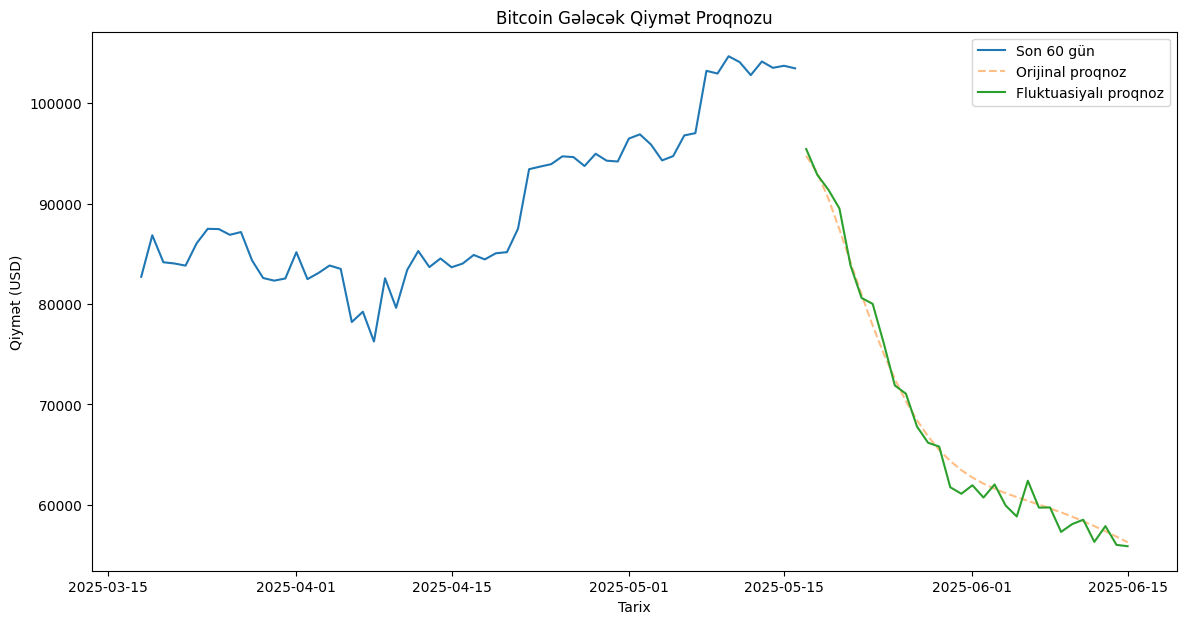

In [13]:
plt.figure(figsize=(14, 7))
plt.plot(btc_data.index[-60:], btc_data['Close'].values[-60:], label='Son 60 gün')


fluctuation_scale = np.mean(future_predictions) * 0.02
random_fluctuations = np.random.normal(0, fluctuation_scale, size=future_predictions.shape)
natural_predictions = future_predictions + random_fluctuations

plt.plot(future_dates, future_predictions, '--', alpha=0.5, label='Orijinal proqnoz')
plt.plot(future_dates, natural_predictions, label='Fluktuasiyalı proqnoz')

plt.title('Bitcoin Gələcək Qiymət Proqnozu')
plt.xlabel('Tarix')
plt.ylabel('Qiymət (USD)')
plt.legend()
plt.show()

## Proqnozlaşdırılan qiymətləri göstəririk

In [14]:
print("\nNövbəti 30 gün üçün Bitcoin qiymət proqnozu (fluktuasiyalarla):")
forecast_df = pd.DataFrame({
    'Tarix': future_dates, 
    'Orijinal Proqnoz (USD)': future_predictions.flatten(),
    'Fluktuasiyalı Proqnoz (USD)': natural_predictions.flatten()
})
forecast_df


Növbəti 30 gün üçün Bitcoin qiymət proqnozu (fluktuasiyalarla):


,Tarix,Orijinal Proqnoz (USD),Fluktuasiyalı Proqnoz (USD)
0,2025-05-17,94774.484375,95452.800094
1,2025-05-18,93072.968750,92884.154221
2,2025-05-19,90514.820312,91399.307525
3,2025-05-20,87443.828125,89523.686502
4,2025-05-21,84173.484375,83853.723173
5,2025-05-22,80931.093750,80611.354968
6,2025-05-23,77861.656250,80018.238401
7,2025-05-24,75048.281250,76096.294553
8,2025-05-25,72532.039062,71890.922127
9,2025-05-26,70326.562500,71067.485632
